In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

sdf_file_name = "solubility_2007.sdf"


def get_fingerprint(molecule, sep=",", nBits=2048):
    """
    This is moved to separate function to change in 1 place when necessary
    returns string (probably ready for saving to .csv)
    warning!!! don't use GetMorganFingerprint(...)
    """
    for x in AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=nBits):
        if x not in set([1, 0]):
            print(x, molecule)
    return sep.join([str(x) for x in AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=nBits)])
def load_database(filename, sep=","):
    if not os.path.exists(filename):
        print("sdf database couldn't be found at '%s'" % filename)
        exit(1)
    suppl = Chem.SDMolSupplier(filename)
    for mol in suppl:
        yield sep.join([mol.GetProp('EXPT'), get_fingerprint(mol, sep=sep)])

In [3]:
bbb_file = "bbb.csv"
f = open(bbb_file, 'w')
for x in pd.read_csv("blood_barriers.csv").as_matrix():
    mol = Chem.MolFromSmiles(x[1])
    if mol is None:
        continue
    f.write(",".join([str(x[0]), get_fingerprint(mol)])+"\n")

In [4]:
from sklearn import tree
from blagging import BlaggingClassifier

In [8]:
from sklearn.ensemble import BaggingClassifier

In [5]:
clf = tree.DecisionTreeClassifier()

In [6]:
data = pd.read_csv(bbb_file, header=None, sep=',').apply(lambda x: x.astype('bool')).drop_duplicates()
Y = data[0] 
X = data.loc[:, 1:]
from sklearn.cross_validation import train_test_split
x_tr,  x_test, y_tr, y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
clf = clf.fit(x_tr, y_tr)
print clf.score(x_tr, y_tr), clf.score(x_test, y_test)

0.996677740864 0.789473684211


In [9]:
bc = BaggingClassifier()
bc = bc.fit(x_tr, y_tr)
print bc.score(x_tr, y_tr), bc.score(x_test, y_test)

0.986710963455 0.697368421053


In [10]:
data[0].value_counts()

True     248
False    129
Name: 0, dtype: int64

In [11]:
248.0/(129+248)

0.6578249336870027

In [19]:
from sklearn.metrics import roc_curve, auc
from imblearn.combine import SMOTEENN
sm = SMOTEENN()
from sklearn.svm import SVC, LinearSVC

In [39]:
def draw_ROC_for_classifiers(classifiers, X, Y, test_size=0.2):
    x_train,  x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    x_train, y_train = sm.fit_sample(x_train, y_train)
    plt.figure()
    for i, k in enumerate(classifiers):
        classifier = classifiers[k].fit(x_train, y_train)
        print "%s: %0.3f, %0.3f" % (k, classifier.score(x_train, y_train), classifier.score(x_test, y_test))
        probs = classifier.decision_function(x_test) if isinstance(classifier, SVC) or isinstance(classifier, LinearSVC) else classifier.predict_proba(x_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (k, roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

LinearSVC: 1.000, 0.618
bagging classifier: 0.991, 0.697
blagging classifier: 0.988, 0.724
SVC: 0.589, 0.342
decision tree: 1.000, 0.632


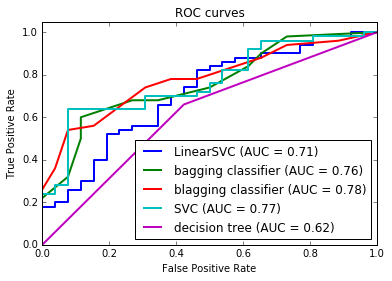

In [41]:
draw_ROC_for_classifiers({
        'decision tree' : tree.DecisionTreeClassifier(),
        'bagging classifier' : BaggingClassifier(),
        'blagging classifier': BlaggingClassifier(),
        'SVC': SVC(),
        'LinearSVC': LinearSVC()
    }, X, Y)